In [1]:
import pandas as pd

In [6]:
df1 = pd.read_csv("res_meta_fixed.txt" , sep='\t')
df2 = pd.read_csv("res_meta_rand.txt" , sep='\t')

/tmp/ipykernel_3490961/606625367.py:65: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


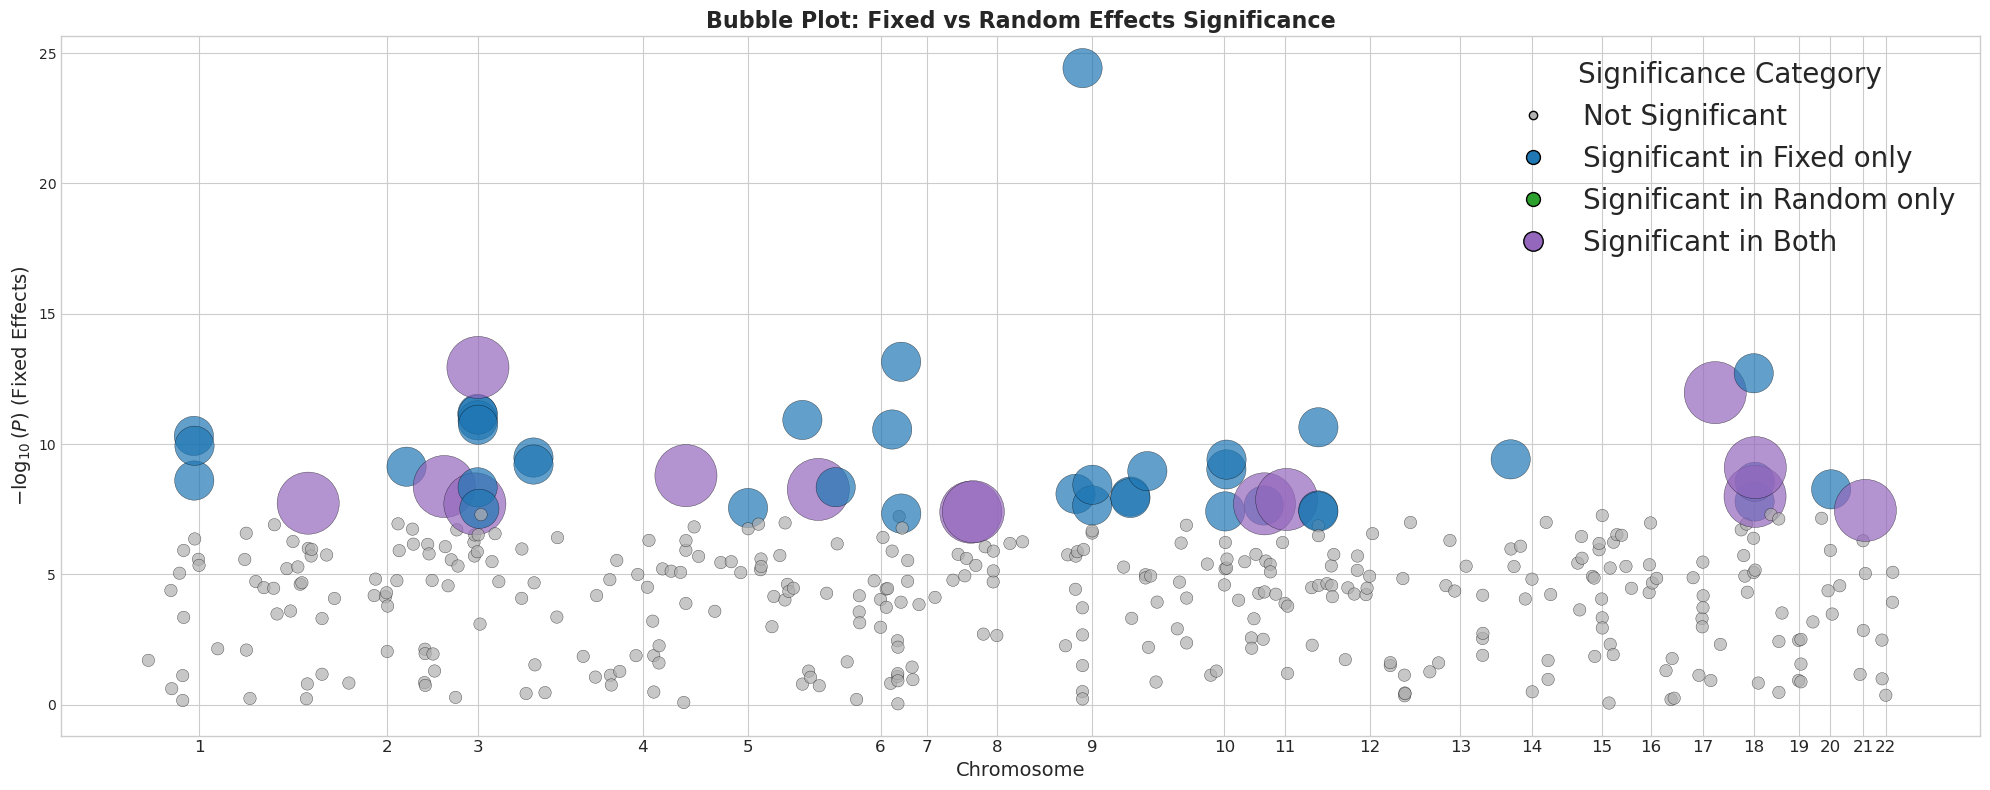

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Merge & prepare data ---
merged = pd.merge(
    df1, df2, on=['SNP', 'BP', 'CHR'], suffixes=('_fixed', '_random')
)

# Significance threshold
alpha = 5e-8

# Compute significance flags
sig_fixed = merged['Pval_fixed'] < alpha
sig_random = merged['Pval_random'] < alpha

# Categorize:  
# 0 = not significant
# 1 = significant in fixed only
# 2 = significant in random only
# 3 = significant in both
def sig_category(fixed, random):
    if fixed and random:
        return 3
    elif fixed:
        return 1
    elif random:
        return 2
    else:
        return 0

merged['sig_category'] = [sig_category(f, r) for f, r in zip(sig_fixed, sig_random)]

# Bubble sizes (bigger & proportional)
size_map = {0: 80, 1: 800, 2: 800, 3:2000}
color_map = {
    0: '#B0B0B0',   # grey
    1: '#1f77b4',   # blue → fixed only
    2: '#2ca02c',   # green → random only
    3: '#9467bd'    # purple → both
}

merged['bubble_size'] = merged['sig_category'].map(size_map)
merged['bubble_color'] = merged['sig_category'].map(color_map)

# --- Create cumulative BP for chromosome gaps ---
merged = merged.sort_values(['CHR', 'BP'])
merged['CHR'] = merged['CHR'].astype(int)

chrom_offsets = {}
offset = 0
gap = 1e6  # gap between chromosomes
all_chrs = sorted(merged['CHR'].unique())

for chr_ in all_chrs:
    chrom_offsets[chr_] = offset
    max_bp = merged.loc[merged['CHR'] == chr_, 'BP'].max()
    offset += max_bp + gap

merged['cum_bp'] = merged.apply(lambda row: row['BP'] + chrom_offsets[row['CHR']], axis=1)

# --- Plot ---
plt.figure(figsize=(20, 8))
plt.style.use('seaborn-whitegrid')

# Plot bubbles
plt.scatter(
    merged['cum_bp'], -np.log10(merged['Pval_fixed']),
    s=merged['bubble_size'],
    c=merged['bubble_color'],
    alpha=0.7,
    edgecolor='black',
    linewidth=0.3
)

# Chromosome tick positions & vertical lines
tick_positions = []
tick_labels = []
for chr_ in all_chrs:
    chr_data = merged[merged['CHR'] == chr_]
    if not chr_data.empty:
        mid = chr_data['cum_bp'].median()
        tick_positions.append(mid)
        tick_labels.append(str(chr_))
        # vertical line at the start of each chromosome (except first)
        # chr_start = chr_data['cum_bp'].min()
        # if chr_ != all_chrs[0]:
        #     plt.axvline(x=chr_start, color='grey', linestyle='--', linewidth=3)

plt.xticks(tick_positions, tick_labels, fontsize=12)
plt.xlabel('Chromosome', fontsize=14)
plt.ylabel(r'$-\log_{10}(P)$ (Fixed Effects)', fontsize=14)
plt.title('Bubble Plot: Fixed vs Random Effects Significance', fontsize=16, weight='bold')

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Not Significant',
           markerfacecolor=color_map[0], markersize=6, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Significant in Fixed only',
           markerfacecolor=color_map[1], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Significant in Random only',
           markerfacecolor=color_map[2], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Significant in Both',
           markerfacecolor=color_map[3], markersize=14, markeredgecolor='black')
]
plt.legend(handles=legend_elements, title='Significance Category', fontsize=20, title_fontsize=20)

plt.tight_layout()
plt.savefig("bubble_plot_chr_gaps_vlines.jpeg", dpi=600)
plt.show()


In [26]:
df3 = pd.read_csv("PLACO_output.csv")

/tmp/ipykernel_3490961/2724369528.py:63: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


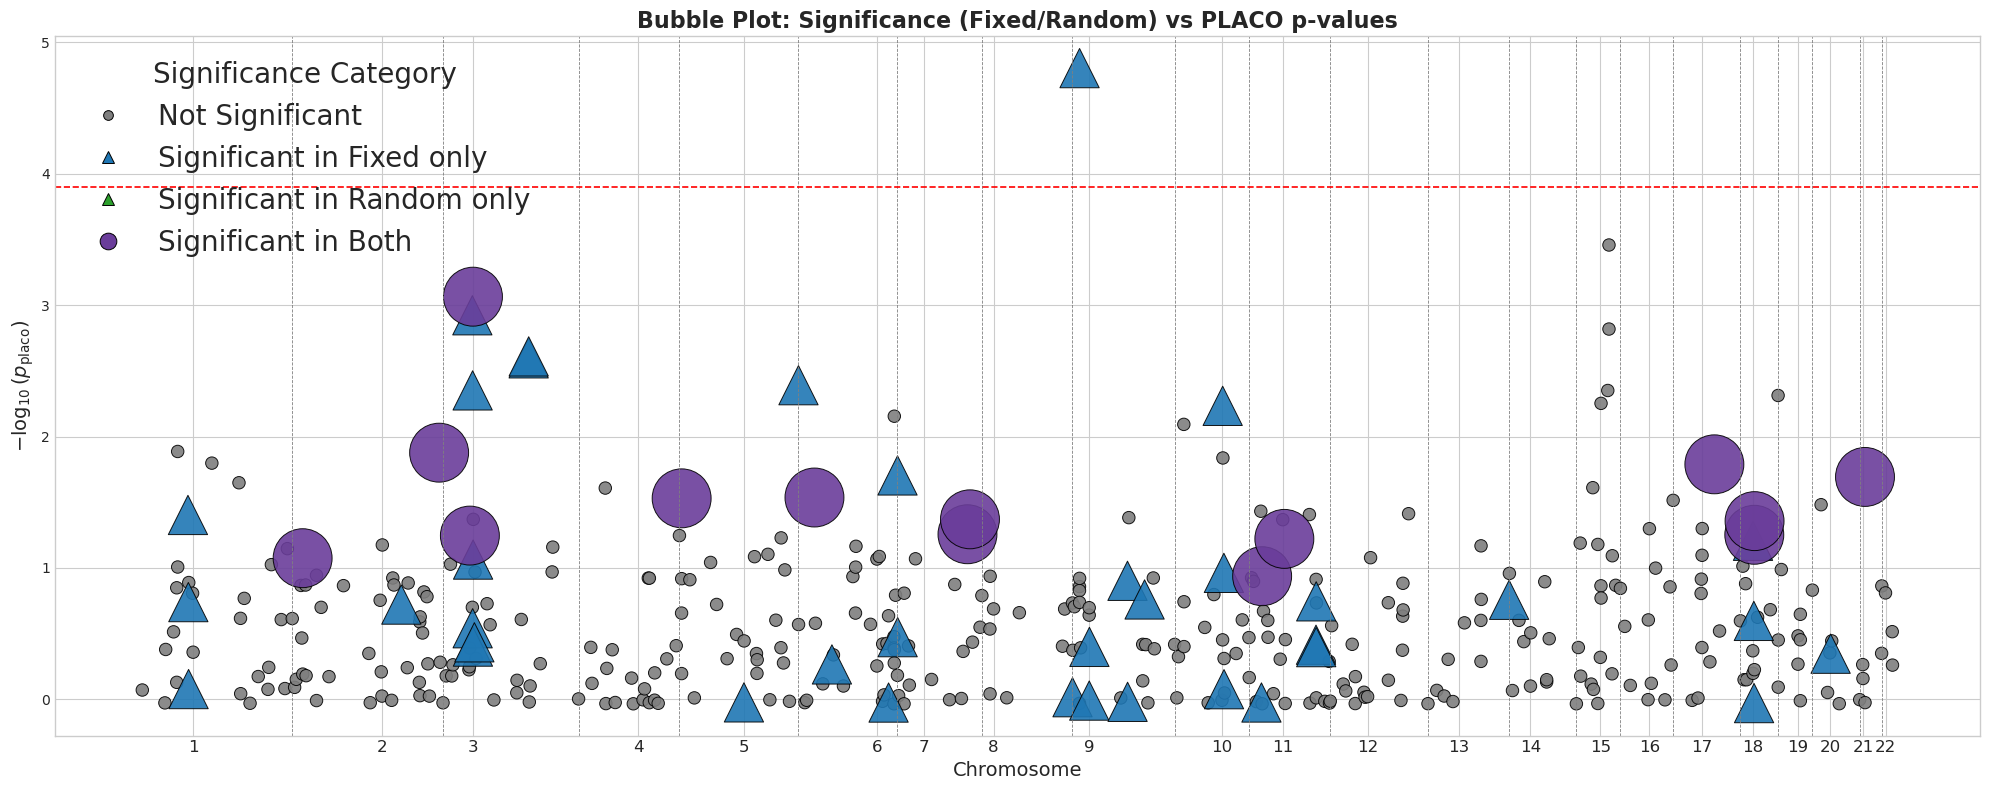

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Merge df1 & df2 ---
merged = pd.merge(
    df1, df2, on=['SNP', 'BP', 'CHR'], suffixes=('_fixed', '_random')
)

# --- Merge df3 ---
merged = pd.merge(
    merged, df3[['SNP', 'BP', 'p.placo']], on=['SNP', 'BP'], how='left'
)

# --- Compute significance ---
alpha = 5e-8
sig_fixed = merged['Pval_fixed'] < alpha
sig_random = merged['Pval_random'] < alpha

def sig_category(fixed, random):
    if fixed and random:
        return 3
    elif fixed:
        return 1
    elif random:
        return 2
    else:
        return 0

merged['sig_category'] = [sig_category(f, r) for f, r in zip(sig_fixed, sig_random)]

# --- Bubble size & color ---
size_map = {0: 80, 1: 800, 2: 800, 3:1800}
color_map = {
    0: '#7f7f7f',   # darker grey
    1: '#1f77b4',   # darker blue
    2: '#2ca02c',   # darker green
    3: '#6a3d9a'    # dark purple
}

merged['bubble_size'] = merged['sig_category'].map(size_map)
merged['bubble_color'] = merged['sig_category'].map(color_map)

# --- cumulative BP with gaps ---
merged = merged.sort_values(['CHR', 'BP'])
merged['CHR'] = merged['CHR'].astype(int)

chrom_offsets = {}
offset = 0
gap = 1e6
all_chrs = sorted(merged['CHR'].unique())

for chr_ in all_chrs:
    chrom_offsets[chr_] = offset
    max_bp = merged.loc[merged['CHR'] == chr_, 'BP'].max()
    offset += max_bp + gap

merged['cum_bp'] = merged.apply(lambda row: row['BP'] + chrom_offsets[row['CHR']], axis=1)

# --- Plot ---
plt.figure(figsize=(20, 8))
plt.style.use('seaborn-whitegrid')

# Plot by group
markers = {0: 'o', 1: '^', 2: '^', 3: 'o'}

for group in [0, 1, 2, 3]:
    data = merged[merged['sig_category'] == group]
    plt.scatter(
        data['cum_bp'], -np.log10(data['p.placo']),
        s=data['bubble_size'],
        c=data['bubble_color'],
        alpha=0.9,
        edgecolor='black',
        linewidth=0.7,
        marker=markers[group],
        label=None
    )

# --- Chromosome ticks & vertical lines ---
tick_positions = []
tick_labels = []
for chr_ in all_chrs:
    chr_data = merged[merged['CHR'] == chr_]
    if not chr_data.empty:
        mid = chr_data['cum_bp'].median()
        tick_positions.append(mid)
        tick_labels.append(str(chr_))
        chr_start = chr_data['cum_bp'].min()
        if chr_ != all_chrs[0]:
            plt.axvline(x=chr_start, color='grey', linestyle='--', linewidth=0.6)

plt.xticks(tick_positions, tick_labels, fontsize=12)
plt.xlabel('Chromosome', fontsize=14)
plt.ylabel(r'$-\log_{10}(p_{\mathrm{placo}})$', fontsize=14)
plt.title('Bubble Plot: Significance (Fixed/Random) vs PLACO p-values', fontsize=16, weight='bold')

# --- Legend ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Not Significant',
           markerfacecolor=color_map[0], markersize=7, markeredgecolor='black', markeredgewidth=0.7),
    Line2D([0], [0], marker='^', color='w', label='Significant in Fixed only',
           markerfacecolor=color_map[1], markersize=9, markeredgecolor='black', markeredgewidth=0.7),
    Line2D([0], [0], marker='^', color='w', label='Significant in Random only',
           markerfacecolor=color_map[2], markersize=9, markeredgecolor='black', markeredgewidth=0.7),
    Line2D([0], [0], marker='o', color='w', label='Significant in Both',
           markerfacecolor=color_map[3], markersize=12, markeredgecolor='black', markeredgewidth=0.7)
]
plt.legend(handles=legend_elements, title='Significance Category', fontsize=20, title_fontsize=20)
# --- Significance line ---
sig_threshold = 0.05/396
plt.axhline(
    y = -np.log10(sig_threshold),
    color = 'red',
    linestyle = '--',
    linewidth = 1.2,
    label = r'Significance threshold ($5 \times 10^{-8}$)'
)

plt.tight_layout()
plt.savefig("bubble_plot_triangles_and_crisp.jpeg", dpi=700)
plt.show()


In [35]:
sig_fixed = merged['Pval_fixed'] < 5e-8
sig_random = merged['Pval_random'] < 5e-8
# SNPs significant in fixed-effects model
n_fixed = sig_fixed.sum()
print(f"Significant in Fixed-effects model: {n_fixed}")

# SNPs significant in random-effects model
n_random = sig_random.sum()
print(f"Significant in Random-effects model: {n_random}")

# SNPs significant in both
n_both = ((sig_fixed) & (sig_random)).sum()
print(f"Significant in BOTH models: {n_both}")

# SNPs significant in either (fixed or random or both)
n_either = ((sig_fixed) | (sig_random)).sum()
print(f"Significant in EITHER model: {n_either}")


Significant in Fixed-effects model: 51
Significant in Random-effects model: 14
Significant in BOTH models: 14
Significant in EITHER model: 51


In [36]:
sig_both = (sig_fixed & sig_random)
snps_both_df = merged[sig_both].copy()
print(snps_both_df.shape)
snps_both_df.head()


(14, 16)


,SNP,BETA_fixed,SE_fixed,Pval_fixed,Tau_fixed,CHR,BP,BETA_random,SE_random,Pval_random,Tau_random,p.placo,sig_category,bubble_size,bubble_color,cum_bp
37,rs1355178,-0.022040,0.003919,1.860759e-08,0,2,22588525,-0.022040,0.003919,1.860759e-08,0.000000,0.084356,3,1800,#6a3d9a,250201924.0
26,rs2197563,-0.023122,0.003937,4.282009e-09,0,2,233687080,-0.023122,0.003937,4.282009e-09,0.000000,0.013275,3,1800,#6a3d9a,461300479.0
39,rs1506659,-0.024402,0.004348,1.989828e-08,0,3,44912443,-0.024402,0.004348,1.989828e-08,0.000000,0.056767,3,1800,#6a3d9a,508878030.0
2,rs4283605,0.031249,0.004210,1.152355e-13,0,3,49678651,0.032387,0.005714,1.447544e-08,0.000022,0.000862,3,1800,#6a3d9a,513644238.0
22,rs6866171,0.028357,0.004703,1.638048e-09,0,5,7416007,0.028357,0.004703,1.638048e-09,0.000000,0.029549,3,1800,#6a3d9a,836389560.0


In [37]:
snps_both_df.to_csv("significant_in_both_models.csv", index=False)


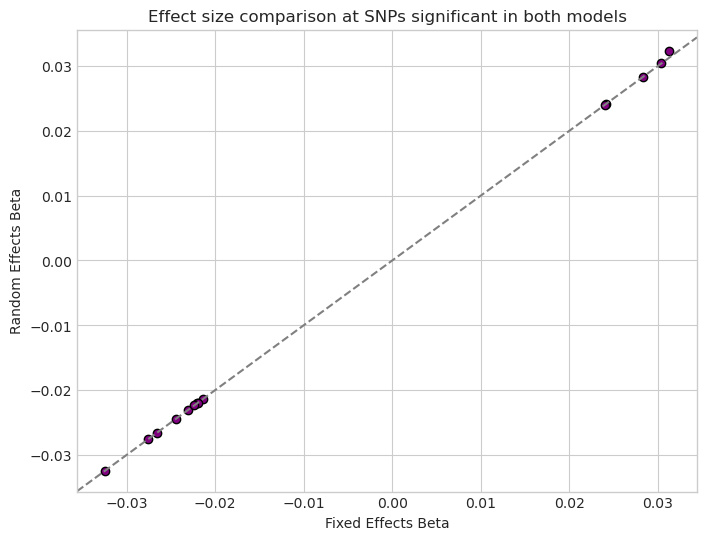

In [38]:
plt.figure(figsize=(8,6))
plt.scatter(snps_both_df['BETA_fixed'], snps_both_df['BETA_random'], c='purple', edgecolor='black')
plt.xlabel("Fixed Effects Beta")
plt.ylabel("Random Effects Beta")
plt.title("Effect size comparison at SNPs significant in both models")
plt.axline((0,0), slope=1, color='grey', linestyle='--')
plt.show()


In [40]:
snps_both_df["SNP"]

37     rs1355178
26     rs2197563
39     rs1506659
2      rs4283605
22     rs6866171
30    rs10947690
49     rs7800391
48    rs10255943
38      rs324293
35      rs876064
4      rs6504548
32    rs12458228
19     rs2958188
44     rs2835713
Name: SNP, dtype: object

In [42]:
cad = pd.read_csv("../1_CAD/CAD_clean.csv")
mdd = pd.read_csv("../2_MDD/MDD_clean.csv")

In [61]:
snp = 'rs'+'2958188'
print(cad[cad['SNP'] == snp])
print(mdd[mdd['SNP'] == snp])


         CHR        SNP        BP A1 A2        OR      BETA   SE_BETA  \
8679662   18  rs2958188  53165959  C  T  1.017979  0.017819  0.009302   

               P         Z       MAF  
8679662  0.05541  1.915651  0.575367  
         CHR        SNP        BP A1 A2       OR      BETA  SE_BETA  \
6662420   18  rs2958188  53165959  C  T  1.02562  0.025297   0.0043   

                    P         Z      MAF  
6662420  2.877000e-09 -5.883092  0.44456  
